In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import timeit
from scipy.integrate import odeint
from IPython.html.widgets import interact, fixed

:0: FutureWarning: IPython widgets are experimental and may change in the future.


##Abstract

This project is a modelling of two galaxies interacting with each other. One galaxy will be in the rest frame and the other galaxy will be moving with respect to the first galaxy. The main galaxy will have 120 orbiting stars in shells within 20%, 30%, 40%, 50%, and 60% of the minimum radius of $25 \: kpc$. As the disrupting galaxy moves towards the main galaxy, the interactions between the stars and the galaxies will deform their orbits. To solve these problems, I have taken the route of using the odeint method to calculate the numerical integrations instead of the Runge-Kutta method described in the paper by Toomre and Toomre. The base questions completed are the direct and retrograde passages. And for the additional questions, I explored the S5 and S7 initial conditions in both the direct and retrograde case.

##Base Question
My base question implimentation took quite some time to get right. The `derivs` function is essentially the same as the ones we've done in class as homework, with the differentials broken into two components. Since the initial conditions of the two base cases I tested will simply be the opposite motion of each other, solving the problem for both wasn't too hard. The transition between direct and retrograde passages only needs to change the direction the stars are moving (as in the velocities).


##Additional Questions
The S5 initial condition case asks to have the $X$ position to be at $25 \: kpc$, the $Y$ position and $X$ velocity to be zero, and the $Y$ velocity to be greater than zero at the minimum of the parabola. The implimentation of these cases were fairly simple. I only needed to change the $y$-position and velocity of the galaxy $S$. The same was done for the S7 initial condition case, but in the $y$ frame.

In [19]:
x=np.linspace(-80,80,100)
y=25-(x)**2/100

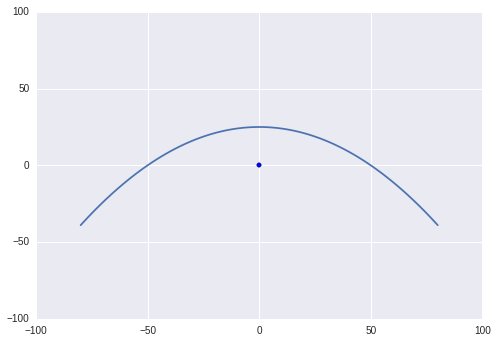

In [22]:
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.plot(x,y),plt.scatter(0,0);

Table 1 gives an overview of the studied encounter types. Here, X, Y, Z, U, V, W, the Cartesian coordinates and velocity components of S in the apex of the encounter hyperbole (or parabola). It is always Y = 0, U = 0. X and Z are given relative to the largest studied $r_0$, which was adopted to 0.5. The amounts of the peak speeds result from the eccentricities $\varepsilon _s$ of the meeting rail. They are twice for $\varepsilon _s$ = 7, for $\varepsilon _s$ = 31 four times for $\varepsilon _s$ = 1. The rotation of the star to M was carried out in the xy-plane in the counterclockwise direction.

In [ ]:
def cm_direct(M,S,gamma):  
    R1, R2, vR1, vR2 = parabolic_ic(M,S,gamma)
    R = np.sqrt(R1**2+R2**2)
    
    if R2==50:
        x=0
        y=R2/2
    elif R2<50:
        x=(R/2)*np.cos(np.arctan(abs(R2/R1)))
        y=(R/2)*np.sin(np.arctan(abs(R2/R1)))
    elif R2>50:
        x=-(R/2)*np.cos(np.arctan(abs(R2/R1)))
        y=(R/2)*np.sin(np.arctan(abs(R2/R1)))
        
    dist = np.array([5,7.5,10,12.5,15])
    N = np.array([12,18,24,30,36])
    theta = [np.arange(0,2*np.pi,2*np.pi/i) for i in N]
    
    rr1, rr2, r1, r2, vrr1, vrr2, vr1, vr2 = [], [], [], [], [], [], [], []
    
    for i in theta:
        rr1.append(np.cos(i))
        rr2.append(np.sin(i))
        vrr1.append(np.sin(i))
        vrr2.append(-np.cos(i))

    vr = np.array([np.sqrt((gamma*M)/i) for i in dist])
    
    r1 = (dist*rr1)-x
    r2 = (dist*rr2)-y
    vr1 = vrr1*vr
    vr2 = vrr2*vr
    
    return r1, r2, vr1, vr2, R1-x, R2-y, vR1, vR2

In [ ]:
def cm_ic(M,S,gamma):
    r1,r2,vr1,vr2,R1,R2,vR1,vR2 = cm_direct(M,S,gamma)
    icR = np.array([R1,R2,vR1,vR2])
    
    dr1 = np.hstack((r1[0],r1[1],r1[2],r1[3],r1[4]))
    dr2 = np.hstack((r2[0],r2[1],r2[2],r2[3],r2[4]))
    dvr1 = np.hstack((vr1[0],vr1[1],vr1[2],vr1[3],vr1[4]))
    dvr2 = np.hstack((vr2[0],vr2[1],vr2[2],vr2[3],vr2[4]))
    
    star_ic = np.transpose(np.vstack((dr1,dr2,dvr1,dvr2)))
    ic_total = np.append(icR,star_ic)
    
    return ic_total, icR, star_ic

In [ ]:
def cm_ode_solutions(t,tsteps,M,S,gamma):
    """
    Solve the differentials with an array of initial conditions and returns lists of positions and velocities.
    
    Parameters
    ----------
    ic : array, list
        Initial conditions [R1,R2,dR1,dR2,r1,r2,dr1,dr2].
    time: float
        The current time t[i].
    M, S: float
        Parameters of the differential equation.
        
    Returns
    -------
    solution : np.ndarray
        The array of the solution. Each row will be the solution vector at 
        that time.
    """
    ic_total, icR, star_ic = cm_ic(M,S,gamma)
    r1,r2,vr1,vr2 = [], [], [], []
    complete_sol = []
    
    
    
    for i in range(120):
        ic = np.append(icR,star_ic[i])
        solution = odeint(derivs, ic, t, args=(M, S), atol=1, rtol=1)
        complete_sol.append(solution)
        r1.append(complete_sol[i][0:tsteps,4])
        r2.append(complete_sol[i][0:tsteps,5])
        vr1.append(complete_sol[i][0:tsteps,6])
        vr2.append(complete_sol[i][0:tsteps,7])
        
    R1 = complete_sol[0][0:tsteps,0]
    R2 = complete_sol[0][0:tsteps,1]
    vR1 = complete_sol[0][0:tsteps,2]
    vR2 = complete_sol[0][0:tsteps,3]
    
    MR1=-R1
    MR2=-R2
    
    return r1, r2, R1, R2, MR1, MR2

In [ ]:
R = [np.sqrt(i**2+j**2) for i,j in zip(R1,R2)]
x,y=[],[]
for i in range(1000):
    if R2[i]==50:
        x.append(0)
        y.append(R2[i]/2)
    elif R2[i]<50:
        x.append((R[i]/2)*np.cos(np.arctan(abs(R2[i]/R1[i]))))
        y.append((R[i]/2)*np.sin(np.arctan(abs(R2[i]/R1[i]))))
    elif R2[i]>50:
        x.append(-(R[i]/2)*np.cos(np.arctan(abs(R2[i]/R1[i]))))
        y.append((R[i]/2)*np.sin(np.arctan(abs(R2[i]/R1[i]))))

In [ ]:
def plot_stuff(direct_r1, direct_r2, R1, R2, x, y, p=0):
    plt.figure(figsize=(6,6))
    MR1,MR2=-R1,-R2
    plt.xlim(-80,80)
    plt.ylim(-80,80)
    for i in range(120):
        plt.scatter(direct_r1[i][p]-x[p],direct_r2[i][p]-abs(y[p]),c='r',s=6);
    plt.scatter(R1[p]-x[p],R2[p]-y[p],c='k')
    plt.scatter(0,0,c='b')
    plt.scatter(MR1[p]+x[p],MR2[p]+y[p],c='g')
    
    plt.show()

In [ ]:
interact(plot_stuff, p=(0,999), direct_r1=fixed(direct_r1), direct_r2=fixed(direct_r2), R1=fixed(R1), R2=fixed(R2), x=fixed(x), y=fixed(y));

In [ ]:
def cm_plot_ode(t, whichplot, tsteps, M, S, gamma, n=0):
    """
    Plots the stars and galaxies positions as a function of time, controlled by the user.
    """
    d_r1, d_r2, r_r1, r_r2, R1, R2 = ode_solutions(t,tsteps,M,S,gamma)
    MR1=-R1
    Mr2=-R2
    
    R = [np.sqrt(i**2+j**2) for i,j in zip(R1,R2)]
    x,y=[],[]
    for i in range(1000):
        if R2[i]==50:
            x.append(0)
            y.append(R2[i]/2)
        elif R2[i]<50:
            x.append((R[i]/2)*np.cos(np.arctan(abs(R2[i]/R1[i]))))
            y.append((R[i]/2)*np.sin(np.arctan(abs(R2[i]/R1[i]))))
        elif R2[i]>50:
            x.append(-(R[i]/2)*np.cos(np.arctan(abs(R2[i]/R1[i]))))
            y.append((R[i]/2)*np.sin(np.arctan(abs(R2[i]/R1[i]))))
    
    plt.figure(figsize=(9,9))
    
    for o in range(120):
        plt.scatter(d_r1[o][n]-x[n],d_r2[o][n]-y[n], label='m', color='r', s=6)
        
    plt.scatter(MR1[n]+x[n], MR2[n]+y[n], label='M', color='g')
    plt.scatter(R1[n]-x[n], R2[n]-y[n], label='S', color='k')
    plt.scatter(0,0, label='cm',color='b')
    plt.tick_params(axis='x', labelbottom='off')
    plt.tick_params(axis='y', labelleft='off')
    
    plt.xlim(-150,150)
    plt.ylim(-150,150)
    
    plt.show()

In [ ]:
interact(cm_plot_ode, n=(0,len(t)-1), t=fixed(t), whichplot=fixed(whichplot), tsteps=fixed(tsteps), M=fixed(M), S=fixed(S), gamma=fixed(gamma));

In [3]:
Y=55
X=25-(Y**2)/(100)
np.linalg.norm([X,Y]),X

(55.25, -5.25)

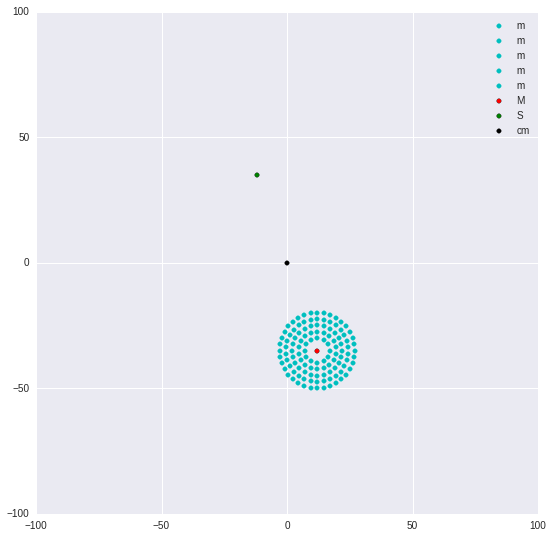

In [30]:
# center of mass
R2=70
R1=25-(R2**2)/100
R=np.sqrt(R1**2+R2**2)

if R2==50:
    x=0
    y=R2/2
elif R2<50:
    x=(R/2)*np.cos(np.arctan(abs(R2/R1)))
    y=(R/2)*np.sin(np.arctan(abs(R2/R1)))
elif R2>50:
    x=-(R/2)*np.cos(np.arctan(abs(R2/R1)))
    y=(R/2)*np.sin(np.arctan(abs(R2/R1)))

plt.figure(figsize=(9,9))
r_min = 25
N = 12
i = 0.2
while i<=0.6:
    theta = np.arange(0, 2*np.pi, 2*np.pi/N)
    a = i*r_min*np.sin(theta)
    b = i*r_min*np.cos(theta)
    plt.scatter(a-x,b-y, label='m',color='c')
    i += 0.1
    N += 6

plt.xlim(-100,100)
plt.ylim(-100,100)

plt.scatter(0-x,0-y,c='r',label='M')
plt.scatter(R1-x,R2-y,c='g',label='S')
plt.scatter(0,0,c='k',label='cm')
plt.legend();

In [31]:
theta=np.linspace(0,2*np.pi,1000)
mu=0.3*np.arange(-10,11)

In [75]:
a=25/8
b=np.sqrt(625-50*a)
h=25-a

In [76]:
h

21.875

In [93]:
y=np.linspace(-70,71,500)

In [94]:
x=h+a*np.sqrt(1-(y**2/b**2))

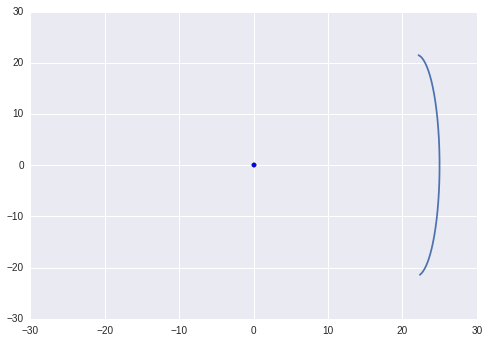

In [95]:
plt.plot(x,y)
plt.scatter(0,0)
plt.xlim(-30,30),plt.ylim(-30,30);

In [87]:
np.arccos(1/7)*(180/np.pi)

81.786789298261809

In [33]:
(6.67384e-11)*(1/3.08567758e19)**3*(1.98855e30)*(3.1556926e16)**2*10**1

4498316.963439859

In [6]:
4.4983169634398597e5

449831.69634398597

In [3]:
r_min = 25
N = 12
i = 0.2
dist=np.array([0.2,0.3,0.4,0.5,0.6])*r_min
num_of_stars=np.array([12,18,24,30,36])
# x=[]
# y=[]
# while i<=0.6:
#     theta = np.arange(0, 2*np.pi, 2*np.pi/N)
#     x.append(i*r_min*np.sin(theta))
#     y.append(i*r_min*np.cos(theta))
# #     plt.scatter(x,y, label='m')
#     i += 0.1
#     N += 6


In [34]:
def cir_plot():
    plt.figure(figsize=(9,9))
    r_min = 25
    N = 12
    i = 0.2
    Y=55
    X=25-(Y**2)/(100)
    M=-X
    L=-Y
    while i<=0.6:
        theta = np.arange(0, 2*np.pi, 2*np.pi/N)
        x = i*r_min*np.sin(theta)+M
        y = i*r_min*np.cos(theta)+L
        plt.scatter(x,y, label='m',color='c')
        i += 0.1
        N += 6
    plt.scatter(0,0, color='red', label='cm')
    plt.xlim(-80,80)
    plt.ylim(-80,80)
    plt.scatter(X,Y, label='S')
    plt.scatter(M,L, color='g', label='M')
    dX_dY = -Y/50
    
    plt.legend()

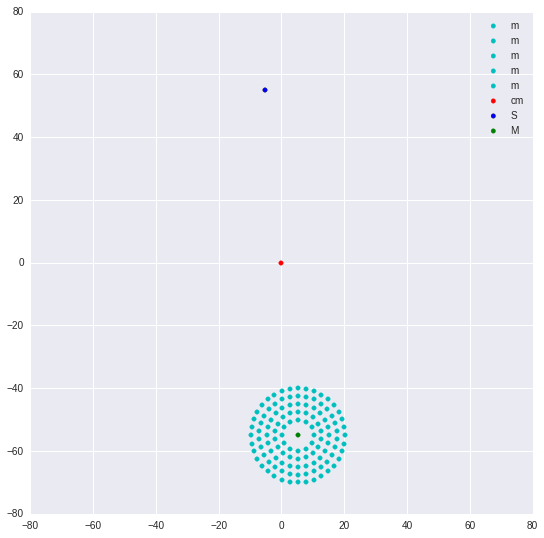

In [35]:
cir_plot()

In [53]:
R2=55
np.sqrt(625+((R2**4)/10000)-(R2**2)/2)
np.sqrt(55**2-5.25**2)

54.748858435587493

In [6]:
#     dr_array = np.array([dr1,dr2])
#     dR_array = np.array([dR1,dR2])
    
#     d2r_array = np.array([d2r1,d2r2])
#     d2R_array = np.array([d2R1,d2R2])
    
#     drvec = np.array([dr_array,dR_array])

#     r_vector = np.array([r1,r2])
#     R_vector = np.array([R1,R2])

#     r = np.linalg.norm([r1,r2])
#     R = np.linalg.norm([R1,R2])
#     rho = np.linalg.norm(rho_vector)

# start=timeit.default_timer()

# end=timeit.default_timer()
# print(end-start)

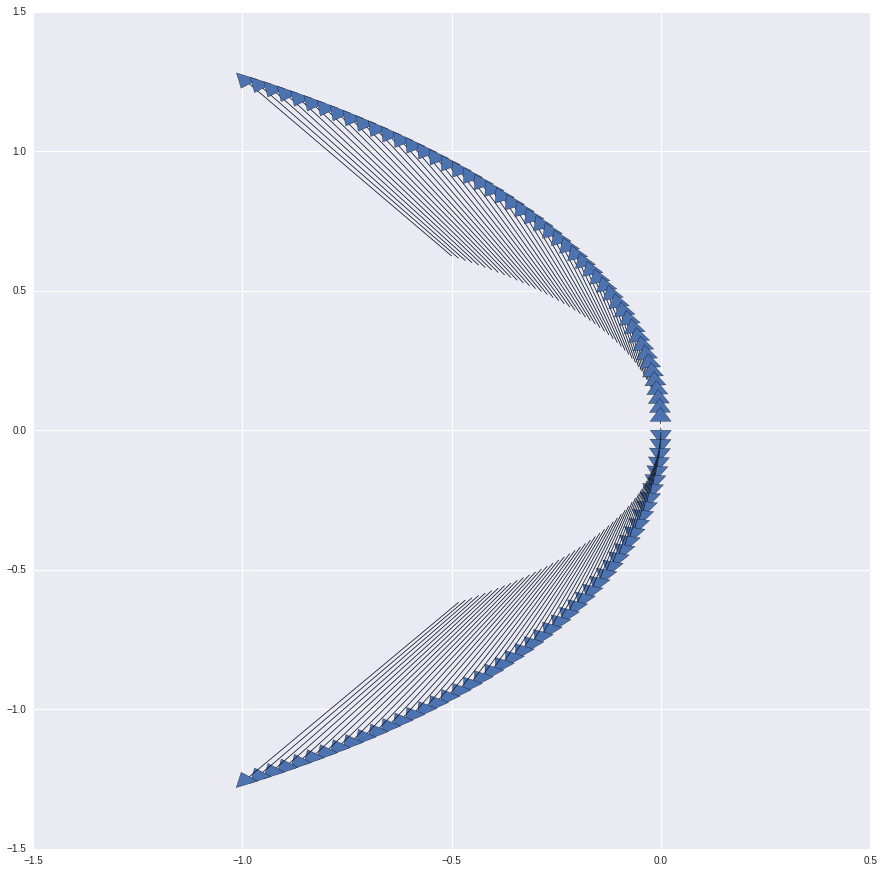

In [9]:
plt.figure(figsize=(15,15))
for i in range(len(X)-1):
    plt.arrow(vx[i],vy[i],vx[i+1],vy[i+1], head_width=0.05, head_length=0.05);
plt.xlim(-1.5,0.5), plt.ylim(-1.5,1.5);

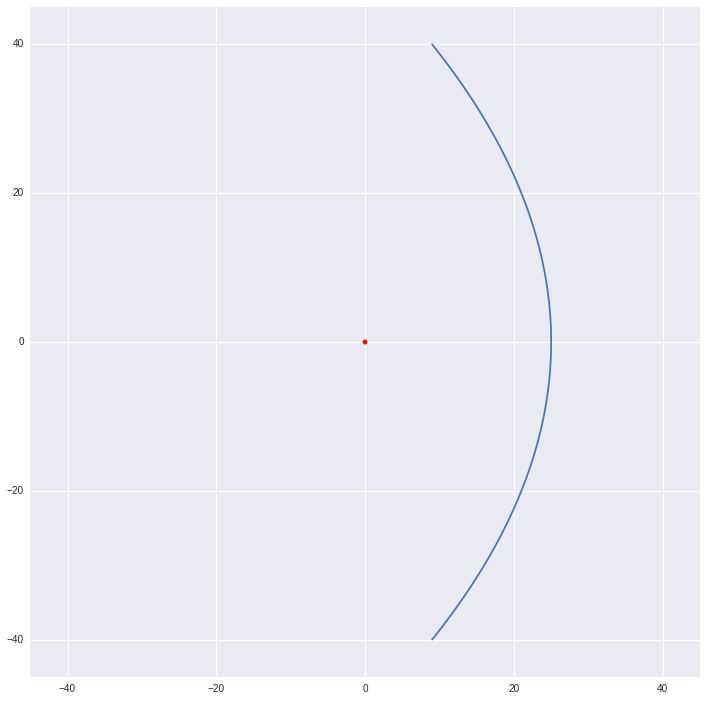

In [12]:
plt.figure(figsize=(12,12))
Y=np.linspace(-40,40,100)
X=-(Y**2)/(100)+25
dX_dY = -Y/50
theta = np.arctan(dX_dY)
vx=-dX_dY*np.cos(theta)
vy=dX_dY*np.sin(theta)
# XX,YY,U,V = np.array([X,Y,vx,vy])
# f = plt.quiver(XX,YY,U,V, width=0.001)
# for i in range(len(X)-1):
#     plt.arrow(vx[i],vy[i],vx[i+1],vy[i+1], head_width=0.05, head_length=0.05)
plt.plot(X,Y), plt.scatter(0,0,color='r')
plt.xlim(-45,45),plt.ylim(-45,45);

In [ ]:
# def cm_ic(M,S,gamma):
#     direct_r1, direct_r2, direct_vr1, direct_vr2 = direct_ic(M,gamma)
#     retro_r1, retro_r2, retro_vr1, retro_vr2 = retro_ic(M,gamma)
#     SR1,SR2,SvR1,SvR2 = parabolic_ic(M,S,gamma)
#     icSR = np.array([SR1,SR2,SvR1,SvR2])
#     MR1=-SR1
#     MR2=-SR2
#     MvR1=-SvR1
#     MvR2=-SvR2
#     icMR = np.array([MR1,MR2,MvR1,MvR2])
    
#     direct_mr1 = np.hstack((direct_r1[0],direct_r1[1],direct_r1[2],direct_r1[3],direct_r1[4]))
#     direct_mr2 = np.hstack((direct_r2[0],direct_r2[1],direct_r2[2],direct_r2[3],direct_r2[4]))
#     direct_mvr1 = np.hstack((direct_vr1[0],direct_vr1[1],direct_vr1[2],direct_vr1[3],direct_vr1[4]))
#     direct_mvr2 = np.hstack((direct_vr2[0],direct_vr2[1],direct_vr2[2],direct_vr2[3],direct_vr2[4]))

#     retro_mr1 = np.hstack((retro_r1[0],retro_r1[1],retro_r1[2],retro_r1[3],retro_r1[4]))
#     retro_mr2 = np.hstack((retro_r2[0],retro_r2[1],retro_r2[2],retro_r2[3],retro_r2[4]))
#     retro_mvr1 = np.hstack((retro_vr1[0],retro_vr1[1],retro_vr1[2],retro_vr1[3],retro_vr1[4]))
#     retro_mvr2 = np.hstack((retro_vr2[0],retro_vr2[1],retro_vr2[2],retro_vr2[3],retro_vr2[4]))
    
#     direct_star_ic = np.transpose(np.vstack((direct_mr1,direct_mr2,direct_mvr1,direct_mvr2)))
#     retro_star_ic = np.transpose(np.vstack((retro_mr1,retro_mr2,retro_mvr1,retro_mvr2)))
#     direct_ic_total = np.append(icR,direct_star_ic)
#     retro_ic_total = np.append(icR,retro_star_ic)
    
#     cm_direct=np.append(icR,direct_star_ic)
    
#     return direct_ic_total, retro_ic_total, icR, direct_star_ic, retro_star_ic